In [33]:
import pandas as pd
import numpy as np
from itertools import product
from datetime import datetime,date, timedelta
from google.cloud import storage
from google.cloud.storage import Blob
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
client = storage.Client(project="ds5500")

INPUT_PATH = "gs://kkbox-data/50_pct_undersample/"
bucket = client.get_bucket("kkbox-data")
split="val" #use "train", "val" or "test"

# Process User Logs

In [34]:
user_logs = pd.read_csv(INPUT_PATH + "{}_user_logs.csv".format(split))
#user_logs = pd.read_csv("gs://dataprep-staging-a4a9adec-2491-40c1-8c86-fe48a78ef1f1/ribaudo.a@husky.neu.edu/jobrun/train_50_pct_user_logs.csv")
user_logs.loc[:,["date"]]=pd.to_datetime(user_logs.date).dt.date
members_df = pd.read_csv(INPUT_PATH + "{}_members_transformed.csv".format(split))
y = members_df.loc[:,["msno","is_churn"]].copy()

In [35]:
# Remove user_logs that don't exist in members df
msno_diff = list(set(user_logs.msno) - set(members_df.msno)) #difference in 2 sets
user_logs = user_logs[~user_logs["msno"].isin(msno_diff)]

### Log Normalize

In [36]:
# Standardize and clip the values at 2 * std because we want to be very sensitive at the lower end of the data.
# In other words, it's safe to assume that those playing tracks above 2*std won't churn, we want to investigate the distribution of data below that point
std_scaler = preprocessing.StandardScaler()
max_scaler = preprocessing.MinMaxScaler()

for col in ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"]:
    count_clip = np.clip(user_logs[col].values.reshape(-1,1), a_min=0,a_max=user_logs[col].values.reshape(-1,1).max())
    col_log = np.log(count_clip +.0001)
    col_std = std_scaler.fit_transform(col_log)
    col_clip = np.clip(col_std, a_min=col_std.min(),a_max=2)
    col_norm = max_scaler.fit_transform(col_clip)
    user_logs[col + "_norm"] = col_norm


In [37]:
user_logs = user_logs.drop(["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"], axis=1)

In [38]:
users = list(set(user_logs.msno))
num_users = len(users)
start_date = date(2016,7,1) # Technically we can go back further, but it introduces a lot of missing data for various users
end_date = date(2017,1,31) # Max date we care about before evaluating churn
#print(f"Num dates: {num_dates}; num_users: {num_users}; padded records to create: {num_dates*num_users}")

In [39]:
# this creates a list containing all dates from start to end
dates = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 1)]
num_dates=len(dates)
# Join the user_log data with the dates created in the previous step
padded_df = pd.DataFrame(product(users, dates), columns=["msno","date"])
padded_df = padded_df.merge(user_logs, how='left', on=["msno","date"]).fillna(0)
padded_df = padded_df.sort_values(by=["msno","date"])

# EDA
Show: heatmap of daily activity for churners and non churners

In [40]:
grouped_df = padded_df.drop(['num_25_norm', 'num_50_norm', 'num_75_norm',
       'num_985_norm', 'num_100_norm', 'num_unq_norm', 'total_secs_norm'],axis=1)
grouped_df["sum_vals"] = padded_df.num_unq_norm #padded_df.drop(["msno","date"],axis=1).sum(axis=1)
pivot_df = grouped_df.pivot(index="msno",columns="date",values="sum_vals")

pivot_df_churn = pivot_df[(y.sort_values("msno")["is_churn"] == 1).values]
pivot_df_nochurn = pivot_df[(y.sort_values("msno")["is_churn"] == 0).values]

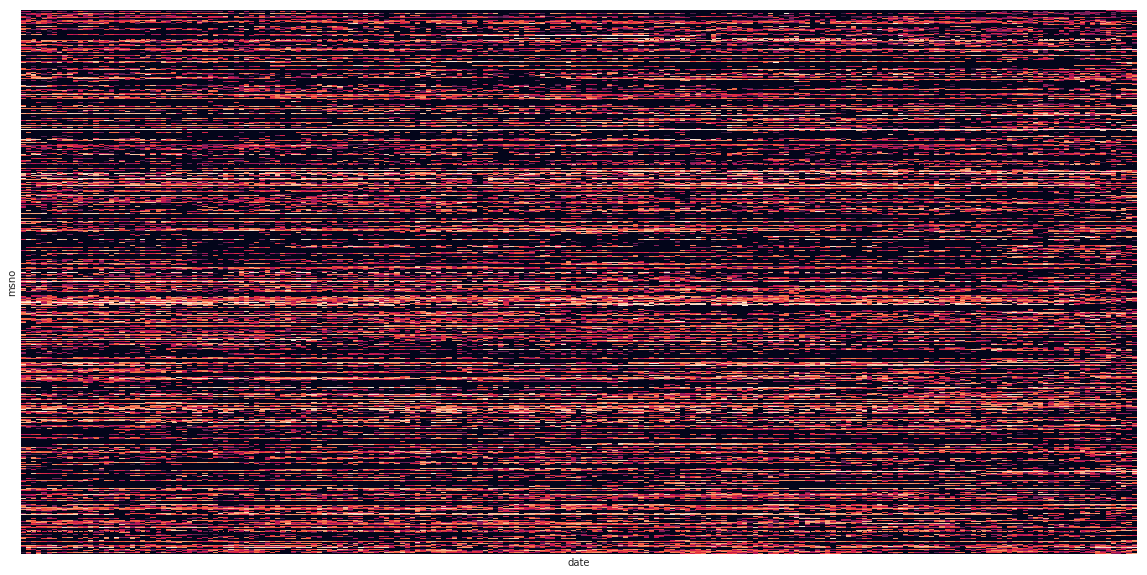

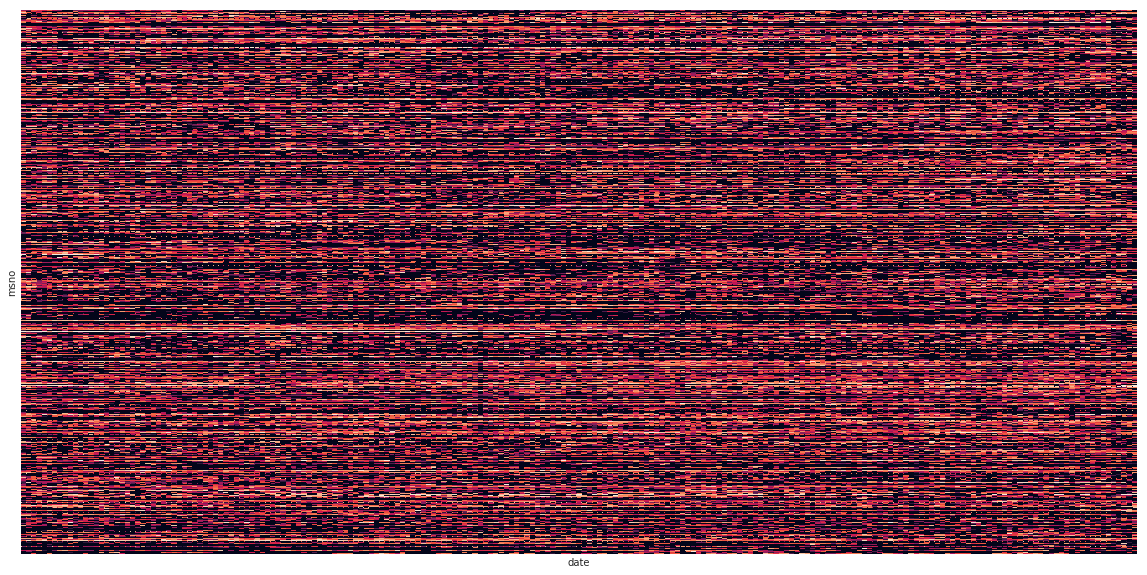

In [41]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(pivot_df_churn,cbar=False,yticklabels=False,xticklabels=False)

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(pivot_df_nochurn,cbar=False,yticklabels=False,xticklabels=False)

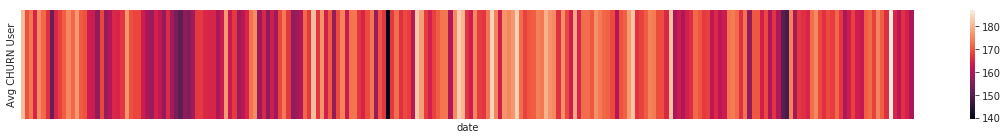

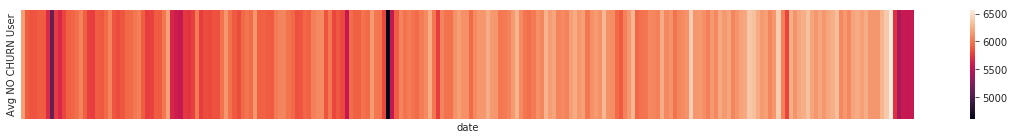

In [42]:
churn_avg = pivot_df_churn.copy()
churn_avg["Avg CHURN User"]="foo"
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 2))
    ax = sns.heatmap(churn_avg.groupby("Avg CHURN User").sum(),cbar=True,yticklabels=False,xticklabels=False)


no_churn_avg = pivot_df_nochurn.copy()
no_churn_avg["Avg NO CHURN User"]="foo"
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 2))
    ax = sns.heatmap(no_churn_avg.groupby("Avg NO CHURN User").sum(),cbar=True,yticklabels=False,xticklabels=False)

## Reshape User Logs and Save

In [43]:
# Reshape df to numpy 3d matrix
padded_df_data = padded_df.iloc[:,2:]
num_cols = len(padded_df_data.columns)
padded_array = padded_df_data.values.reshape(num_users,num_dates,num_cols)
np.save("{}_user_logs_padded".format(split),padded_array)
padded_array.shape

(21517, 215, 7)

In [44]:
# Move numpy file to GCS
blob = Blob("50_pct_undersample/{}_user_logs_padded.npy".format(split), bucket)
with open("{}_user_logs_padded.npy".format(split), "rb") as my_file:
    blob.upload_from_file(my_file)

# Aggregate by Week

In [59]:
# Reload because the norms were taken from daily data
user_logs = pd.read_csv(INPUT_PATH + "{}_user_logs.csv".format(split))

In [67]:
# Clip with min=0 to remove invalid counts
for col in ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"]:
    user_logs[col] =  np.clip(user_logs[col].values.reshape(-1,1), a_min=0,a_max=user_logs[col].values.reshape(-1,1).max())

user_logs.loc[:,["date"]]=pd.to_datetime(user_logs.date).dt.date
user_logs["week"] = pd.to_datetime(user_logs['date']).dt.to_period('W')
user_logs_group = user_logs.drop(["date"],axis=1)
user_logs_week = user_logs_group.groupby(["msno","week"]).sum().reset_index()

## Standardize, clip, normalize

In [69]:
# Standardize and clip the values at 2 * std because we want to be very sensitive at the lower end of the data.
# In other words, it's safe to assume that those playing tracks above 2*std won't churn, we want to investigate the distribution of data below that point
std_scaler = preprocessing.StandardScaler()
max_scaler = preprocessing.MinMaxScaler()

for col in ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"]:
    count_clip = np.clip(user_logs_week[col].values.reshape(-1,1), a_min=0,a_max=user_logs_week[col].values.reshape(-1,1).max())
    col_log = np.log(count_clip +.0001)
    col_std = std_scaler.fit_transform(col_log)
    col_clip = np.clip(col_std, a_min=col_std.min(),a_max=2)
    col_norm = max_scaler.fit_transform(col_clip)
    user_logs_week[col + "_norm"] = col_norm


In [72]:
user_logs_labeled = user_logs_week.merge(right=y, how="left", on="msno")
churn_len = len(user_logs_labeled[user_logs_labeled.is_churn == 1])
no_churn_len = len(user_logs_labeled[user_logs_labeled.is_churn == 0])
print(user_logs_labeled[user_logs_labeled.is_churn == 1].num_100_norm.sum() / churn_len)
print(user_logs_labeled[user_logs_labeled.is_churn == 0].num_100_norm.sum() / no_churn_len)

0.7471345566823033
0.7521388825649346


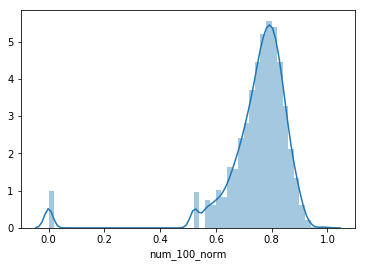

In [73]:
sns.distplot(user_logs_labeled[user_logs_labeled.is_churn == 1].num_100_norm)

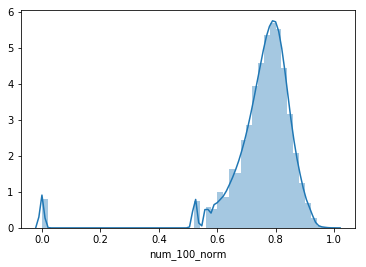

In [75]:
sns.distplot(user_logs_labeled[user_logs_labeled.is_churn == 0].num_100_norm)

In [49]:
user_logs_week = user_logs_week.drop(["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"], axis=1)

In [50]:
users = list(set(user_logs_week.msno))
num_users = len(users)
start_date = date(2016,7,1) # Technically we can go back further, but it introduces a lot of missing data for various users
end_date = date(2017,1,31) # Max date we care about before evaluating churn
#print(f"Num dates: {num_dates}; num_users: {num_users}; padded records to create: {num_dates*num_users}")
# this creates a list containing all dates from start to end
dates = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 1)]
weeks = pd.to_datetime(pd.Series(dates)).dt.to_period('W')

In [51]:
weeks_list = list(set(weeks.astype('str')))
weeks_list.sort()
weeks_list = weeks_list[0:len(weeks_list)-1] # remove last week which includes Feb
num_weeks=len(weeks_list)

In [52]:
# Join the user_log data with the dates created in the previous step
padded_df = pd.DataFrame(product(users, weeks_list), columns=["msno","week"])
# Convert week to string before merge
user_logs_week["week"] = user_logs_week.week.astype('str')

padded_df = padded_df.merge(user_logs_week, how='left', on=["msno","week"]).fillna(0)
padded_df = padded_df.sort_values(by=["msno","week"])

## EDA

In [76]:
grouped_df = padded_df.drop(['num_25_norm', 'num_50_norm', 'num_75_norm',
       'num_985_norm', 'num_100_norm', 'num_unq_norm', 'total_secs_norm'],axis=1)
grouped_df["100_pct"] = padded_df.num_100_norm #padded_df.drop(["msno","date"],axis=1).sum(axis=1)
pivot_df = grouped_df.pivot(index="msno",columns="week",values="100_pct")
pivot_df_churn = pivot_df[(y.sort_values("msno")["is_churn"] == 1).values]
pivot_df_nochurn = pivot_df[(y.sort_values("msno")["is_churn"] == 0).values]

In [ ]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(pivot_df_churn,cbar=True,yticklabels=False,xticklabels=False)

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(10, 5))
    ax = sns.heatmap(pivot_df_nochurn,cbar=True,yticklabels=False,xticklabels=False)

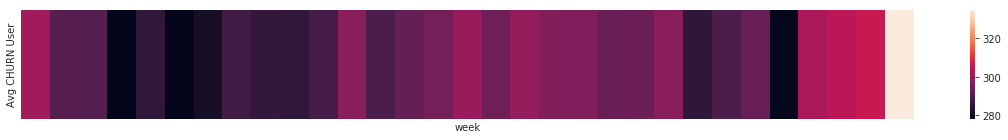

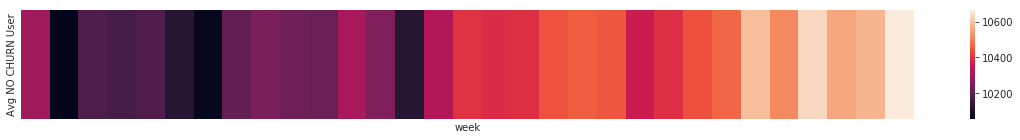

In [55]:
churn_avg = pivot_df_churn.copy()
churn_avg["Avg CHURN User"]="foo"
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 2))
    ax = sns.heatmap(churn_avg.groupby("Avg CHURN User").sum(),cbar=True,yticklabels=False,xticklabels=False)


no_churn_avg = pivot_df_nochurn.copy()
no_churn_avg["Avg NO CHURN User"]="foo"
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 2))
    ax = sns.heatmap(no_churn_avg.groupby("Avg NO CHURN User").sum(),cbar=True,yticklabels=False,xticklabels=False)

## Reshape and Save

In [56]:
# Reshape df to numpy 3d matrix
padded_df_data = padded_df.iloc[:,2:]
num_cols = len(padded_df_data.columns)
padded_array = padded_df_data.values.reshape(num_users,num_weeks,num_cols)
np.save("{}_user_logs_weekly_padded".format(split),padded_array)
padded_array.shape
# Move numpy file to GCS
blob = Blob("50_pct_undersample/{}_user_logs_weekly_padded.npy".format(split), bucket)
with open("{}_user_logs_weekly_padded.npy".format(split), "rb") as my_file:
    blob.upload_from_file(my_file)